In [22]:
import numpy as np
from scipy.stats import foldnorm
import json

In [24]:
from ml_dtypes import (
    bfloat16,
    float8_e5m2,
    float8_e4m3fn,
    float8_e4m3,
    float4_e2m1fn,
    float6_e3m2fn,
    float6_e2m3fn,
)
from numpy import float16

In [423]:
def all_values(dtype, sort=True, filter_finite=True):
    bit_width = np.dtype(dtype).itemsize * 8
    uint_dtype = {8: np.uint8, 16: np.uint16, 32: np.uint32, 64: np.uint64}[bit_width]
    uints = np.arange(0, 2**bit_width, dtype=uint_dtype)
    values = uints.view(dtype)
    if filter_finite:
        values = values[np.isfinite(values)]
    if sort:
        values = np.sort(values)
    return values


all_values(float8_e5m2), all_values(bfloat16)


def log_hist(a, log_bin_width):
    log_a = np.log2(np.abs(a))
    log_a = log_a[np.isfinite(log_a)]
    bin_edges = np.arange(
        np.floor(log_a.min()), np.ceil(log_a.max() + log_bin_width), log_bin_width
    )[:-3]
    return np.histogram(log_a, bin_edges)


def dtype_log_hist(dtype, log_bin_width=1 / 4):
    return log_hist(
        all_values(dtype, sort=False).astype(np.float64), log_bin_width=log_bin_width
    )


np.set_printoptions(threshold=float("inf"))
# c, b = dtype_log_hist(float8_e4m3)
c, b = dtype_log_hist(float6_e2m3fn)
c, b, len(c), len(b), sum(c)

/var/folders/l1/50_0wv7s3c9cm7vn8f1b_dbw0000gq/T/ipykernel_8081/2166630582.py:17: RuntimeWarning: divide by zero encountered in log2
  log_a = np.log2(np.abs(a))


(array([ 8,  0,  0,  0,  8,  0,  8,  0,  8,  8,  8,  8, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16]),
 array([-3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  ,
        -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
         1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ]),
 24,
 25,
 248)

In [5]:
def calc_bin_counts(e, m, s=1 / 4, fn=False):
    low = 2 - 2 ** (e - 1) - m
    high = 2 ** (e - 1) + int(fn)
    bins = np.arange(low, high + s, s)
    counts = np.array(
        [round(2 ** (0 + i * s) * (2**s - 1)) * 2 for i in range(0, int(m / s))]
        + [round(2 ** (m + i * s) * (2**s - 1)) * 2 for i in range(0, int(1 / s))]
        * (2**e - 1 - int(not fn)),
    )
    if fn:
        counts[-1] -= 2
    return counts, bins


calc_bin_counts(5, 10, fn=True)

(array([  0,   0,   0,   0,   0,   0,   2,   2,   2,   2,   2,   2,   4,
          4,   4,   6,   6,   8,   8,  10,  12,  14,  18,  20,  24,  28,
         34,  40,  48,  58,  68,  82,  96, 116, 138, 162, 194, 230, 274,
        326, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652,
        388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652, 388,
        460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460,
        548, 652, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548,
        652, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652,
        388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652, 388,
        460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460,
        548, 652, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548,
        652, 388, 460, 548, 652, 388, 460, 548, 652, 388, 460, 548, 652,
        388, 460, 548, 652, 388, 460, 548, 650]),
 array([-24.  , -23.75, -23.5 , -23.25, -23.  , -22.75, -22.5 , -22.25,
  

In [69]:
import numpy as np

y = np.float64(2**0.75)
int_view_64 = y.view(np.int64)

# Mantissa mask for float64 (52 bits)
mantissa_mask_64 = 0x000FFFFFFFFFFFFF  # binary: last 52 bits set
mantissa_bits_64 = int_view_64 & mantissa_mask_64

# Convert to a 52-bit binary string
mantissa_str_64 = np.binary_repr(mantissa_bits_64, width=52)
print("Float64 value:", y)
print("Mantissa bits:", mantissa_str_64)


Float64 value: 1.681792830507429
Mantissa bits: 1010111010001001111110011001010110101101001110101101


In [ ]:
# def hist_heights(m, bins=4):
#     xs = 2 ** (np.arange(bins, dtype=np.float64) / bins)
#     xs = xs.view(np.int64)
#     rounding_offset = 2 ** (52 - m) - 1
#     top_k_mantissa_bit_mask = 2**52 - 2 ** (52 - m)
#     xs += rounding_offset
#     xs &= top_k_mantissa_bit_mask
#     xs >>= (52 - m)
#     xs = np.append(xs, 2**m)
#     xs = xs[1:] - xs[:-1]
#     xs *= 2
#     return xs

# hist_heights(10)

array([388, 462, 548, 650])

In [46]:
def hist(e, m, bins=4, fn=False):
    # Recall: for FP64 e=11, m=52
    min_normal_exp = 2 - 2 ** (11 - 1)
    min_sub_exp = min_normal_exp - m
    bin_exps = np.arange(bins * min_sub_exp, bins * (min_normal_exp + 1)) / bins
    bin_edges = 2 ** bin_exps.astype(np.float64)
    bin_bits = bin_edges.view(np.uint64)
    bin_bits += 2 ** (52 - m) - 1  # rounding offset
    bin_bits &= 2**64 - 2 ** (52 - m)  # top-k mantissa bit mask
    bin_bits >>= 52 - m  # remove low masked bits
    bin_bits = np.append(
        bin_bits, np.uint64(2 ** (m + 1))
    )  # add upper-bound for diff stage
    counts = bin_bits[1:] - bin_bits[:-1]  # diff to get hist counts
    counts *= 2  # double for sign bit
    counts = np.append(counts[:-bins], np.tile(counts[-bins:], 2**e - 1 - int(not fn)))
    if fn:
        counts[np.nonzero(counts)[0][-1]] -= 2  # -2 from last non-zero bin
    min_sub_exp = 2 - 2 ** (e - 1) - m
    max_exp = 2 ** (e - 1) + int(fn)
    bin_exps = np.arange(bins * min_sub_exp, bins * max_exp + 1) / bins
    return counts, bin_exps


np.set_printoptions(threshold=float("inf"))
c, b = hist(5, 10, fn=False)
c, b, len(c), len(b)

(array([  2,   0,   0,   0,   2,   0,   2,   0,   2,   2,   2,   2,   4,
          4,   4,   4,   8,   6,   8,  10,  14,  14,  16,  20,  26,  28,
         34,  40,  50,  58,  68,  80,  98, 116, 136, 162, 194, 232, 274,
        324, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650,
        388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650, 388,
        462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462,
        548, 650, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548,
        650, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650,
        388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650, 388,
        462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462,
        548, 650, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548,
        650, 388, 462, 548, 650, 388, 462, 548, 650, 388, 462, 548, 650,
        388, 462, 548, 650], dtype=uint64),
 array([-24.  , -23.75, -23.5 , -23.25, -23.  , -22.75, -22.5 , -22.25,
        

In [571]:
def test_dtype(dtype, e, m, log_bin_width=1 / 4, fn=False):
    calc_counts, calc_bins = hist(e, m, bins=int(1 / log_bin_width), fn=fn)
    actu_counts, actu_bins = dtype_log_hist(dtype, log_bin_width=log_bin_width)
    assert (calc_counts == actu_counts).all(), (calc_counts, actu_counts)
    assert (calc_bins == actu_bins).all(), (calc_bins, actu_bins)
    print("success:", dtype)

In [572]:
test_dtype(float16, 5, 10)

success: <class 'numpy.float16'>


/var/folders/l1/50_0wv7s3c9cm7vn8f1b_dbw0000gq/T/ipykernel_8081/2166630582.py:17: RuntimeWarning: divide by zero encountered in log2
  log_a = np.log2(np.abs(a))


In [573]:
test_dtype(bfloat16, 8, 7)

success: <class 'ml_dtypes.bfloat16'>


/var/folders/l1/50_0wv7s3c9cm7vn8f1b_dbw0000gq/T/ipykernel_8081/2166630582.py:17: RuntimeWarning: divide by zero encountered in log2
  log_a = np.log2(np.abs(a))


In [574]:
test_dtype(float8_e5m2, 5, 2)

success: <class 'ml_dtypes.float8_e5m2'>


/var/folders/l1/50_0wv7s3c9cm7vn8f1b_dbw0000gq/T/ipykernel_8081/2166630582.py:17: RuntimeWarning: divide by zero encountered in log2
  log_a = np.log2(np.abs(a))


In [575]:
test_dtype(float8_e4m3fn, 4, 3, fn=True)

success: <class 'ml_dtypes.float8_e4m3fn'>


/var/folders/l1/50_0wv7s3c9cm7vn8f1b_dbw0000gq/T/ipykernel_8081/2166630582.py:17: RuntimeWarning: divide by zero encountered in log2
  log_a = np.log2(np.abs(a))


In [54]:
start = -50
end = 10
step = 1 / 4  # 2^(1/4)

xs = np.arange(start, end + step, step)
probs = foldnorm.cdf(2**xs, c=0)
ys = np.append(probs[1:], 1.0) - probs
gaussian_data = [{"x": x, "y": y} for x, y in zip(xs, ys) if y > 0]
gaussian_data

[{'x': -50.0, 'y': 1.340842422467887e-16},
 {'x': -49.75, 'y': 1.5945393488962982e-16},
 {'x': -49.5, 'y': 1.8962375388592826e-16},
 {'x': -49.25, 'y': 2.255019172946706e-16},
 {'x': -49.0, 'y': 2.681684844935774e-16},
 {'x': -48.75, 'y': 3.1890786977925964e-16},
 {'x': -48.5, 'y': 3.792475077718565e-16},
 {'x': -48.25, 'y': 4.510038345893412e-16},
 {'x': -48.0, 'y': 5.363369689871548e-16},
 {'x': -47.75, 'y': 6.378157395585193e-16},
 {'x': -47.5, 'y': 7.58495015543713e-16},
 {'x': -47.25, 'y': 9.020076691786825e-16},
 {'x': -47.0, 'y': 1.0726739379743095e-15},
 {'x': -46.75, 'y': 1.2756314791170386e-15},
 {'x': -46.5, 'y': 1.516990031087426e-15},
 {'x': -46.25, 'y': 1.804015338357365e-15},
 {'x': -46.0, 'y': 2.145347875948619e-15},
 {'x': -45.75, 'y': 2.551262958234077e-15},
 {'x': -45.5, 'y': 3.033980062174852e-15},
 {'x': -45.25, 'y': 3.60803067671473e-15},
 {'x': -45.0, 'y': 4.290695751897238e-15},
 {'x': -44.75, 'y': 5.102525916468154e-15},
 {'x': -44.5, 'y': 6.067960124349704e-15

In [55]:
def hist(m, bins=4):
    # Recall: for FP64 e=11, m=52
    min_normal_exp = 2 - 2 ** (11 - 1)
    min_sub_exp = min_normal_exp - m
    bin_exps = np.arange(bins * min_sub_exp, bins * (min_normal_exp + 1)) / bins
    bin_edges = 2 ** bin_exps.astype(np.float64)
    bin_bits = bin_edges.view(np.uint64)
    bin_bits += 2 ** (52 - m) - 1  # rounding offset
    bin_bits &= 2**64 - 2 ** (52 - m)  # top-k mantissa bit mask
    bin_bits >>= 52 - m  # remove low masked bits
    bin_bits = np.append(
        bin_bits, np.uint64(2 ** (m + 1))
    )  # add upper-bound for diff stage
    counts = bin_bits[1:] - bin_bits[:-1]  # diff to get hist counts
    return counts


np.set_printoptions(threshold=float("inf"))
float_data = [[int(c) for c in hist(m)] for m in range(0, 52 + 1)]
data = {"floatData": float_data, "gaussianData": gaussian_data}
with open("data.json", "w") as f:
    json.dump(data, f)
data

{'floatData': [[1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 1, 0],
  [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
  [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2],
  [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 4, 3, 4, 5],
  [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 4, 3, 4, 5, 7, 7, 8, 10],
  [1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   4,
   3,
   4,
   5,
   7,
   7,
   8,
   10,
   13,
   14,
   17,
   20],
  [1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   4,
   3,
   4,
   5,
   7,
   7,
   8,
   10,
   13,
   14,
   17,
   20,
   25,
   29,
   34,
   40],
  [1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   4,
   3,
   4,
   5,
   7,
   7,
   8,
   10,
   13,
   14,
   17,
   20,
   25,
   29,
   34,
   40,
   49,
   58,
   68,
   81],
  [1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   4,
  

In [ ]:
def error(stds, pre, post):
    return ((pre - post) ** 2).mean(-1) ** 0.5 / stds


def linear_quant(xs, min, max):
    return np.clip(xs.round(), min, max)

In [185]:
num_samples = 2**20
log_std_range = (-16, 8 + 1)
stds = 2 ** np.arange(*log_std_range).astype(np.float32)
normals = np.array([np.random.normal(0, 2**std, size=num_samples) for std in stds])
errs = error(stds, normals, normals.round())

/var/folders/l1/50_0wv7s3c9cm7vn8f1b_dbw0000gq/T/ipykernel_26699/3526623598.py:4: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(stds), np.log2(errs))


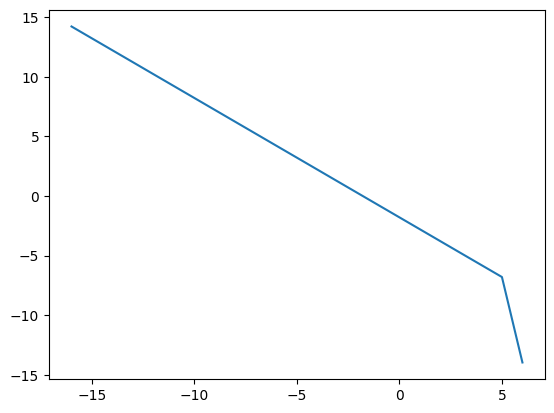

In [186]:
from matplotlib import pyplot as plt


plt.plot(np.log2(stds), np.log2(errs))

In [ ]:
stds, errs * (stds * 12**0.5)

(array([1.5258789e-05, 3.0517578e-05, 6.1035156e-05, 1.2207031e-04,
        2.4414062e-04, 4.8828125e-04, 9.7656250e-04, 1.9531250e-03,
        3.9062500e-03, 7.8125000e-03, 1.5625000e-02, 3.1250000e-02,
        6.2500000e-02, 1.2500000e-01, 2.5000000e-01, 5.0000000e-01,
        1.0000000e+00, 2.0000000e+00, 4.0000000e+00, 8.0000000e+00,
        1.6000000e+01, 3.2000000e+01, 6.4000000e+01, 1.2800000e+02,
        2.5600000e+02], dtype=float32),
 array([1.00048301, 1.00012984, 1.00032916, 1.0007733 , 0.99964164,
        1.00003144, 0.99994836, 0.99985931, 0.99991025, 1.0000799 ,
        0.99951611, 1.00006942, 1.00002888, 0.9993711 , 0.99959949,
        1.00003024, 1.00015306, 1.00036249, 0.99987216, 0.99955138,
        0.99989176, 1.00077051, 0.01395998, 0.        , 0.        ]))

In [192]:
3.46

3.46